In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=dd892545af049b5377bd1b0f9470343c893fff943c9d04c11975034a0e9173bb
  Stored in directory: c:\users\mayank\appdata\local\pip\cache\wheels\59\1b\52\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#initialize the number of epochs and learning rate
learn_rate=1e-4
epochs=20
batch_size=32

In [4]:
directory='D:/self_learning/COVID_mask/New Masks Dataset/train'
categories=['Mask','Non Mask']

In [5]:
data=[]
labels=[]
for category in categories:
    path=os.path.join(directory,category)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image=load_img(img_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        
        data.append(image)
        labels.append(category)
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
data=np.array(data,dtype="float32")
labels=np.array(labels)


In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [7]:
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 1s 0us/step


In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=learn_rate, decay=learn_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...


In [16]:
print("[INFO] training head...")
H = model.fit(
aug.flow(trainX, trainY, batch_size=batch_size),
steps_per_epoch=len(trainX) // batch_size,
validation_data=(testX, testY),
validation_steps=len(testX) // batch_size,
epochs=epochs)

[INFO] training head...
Epoch 1/20
15/15 [==============================] - 17s 898ms/step - loss: 0.7568 - accuracy: 0.5678 - val_loss: 0.5368 - val_accuracy: 0.8017
Epoch 2/20
15/15 [==============================] - 12s 825ms/step - loss: 0.5635 - accuracy: 0.7493 - val_loss: 0.3908 - val_accuracy: 0.9256
Epoch 3/20
15/15 [==============================] - 12s 809ms/step - loss: 0.4381 - accuracy: 0.8725 - val_loss: 0.2871 - val_accuracy: 0.9587
Epoch 4/20
15/15 [==============================] - 12s 826ms/step - loss: 0.3216 - accuracy: 0.9251 - val_loss: 0.2240 - val_accuracy: 0.9669
Epoch 5/20
15/15 [==============================] - 13s 827ms/step - loss: 0.2430 - accuracy: 0.9510 - val_loss: 0.1772 - val_accuracy: 0.9752
Epoch 6/20
15/15 [==============================] - 12s 810ms/step - loss: 0.1805 - accuracy: 0.9746 - val_loss: 0.1480 - val_accuracy: 0.9752
Epoch 7/20
15/15 [==============================] - 12s 821ms/step - loss: 0.1730 - accuracy: 0.9608 - val_loss: 0.128

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("D:/self_learning/COVID_mask/mask_detector.model", save_format="h5")


[INFO] evaluating network...
              precision    recall  f1-score   support

        Mask       0.98      1.00      0.99        61
    Non Mask       1.00      0.98      0.99        60

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121

[INFO] saving mask detector model...


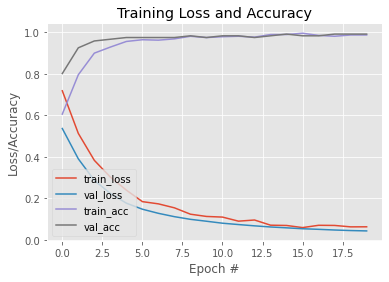

In [19]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")